<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Partial-Plots" data-toc-modified-id="Partial-Plots-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Partial Plots</a></span><ul class="toc-item"><li><span><a href="#概訳" data-toc-modified-id="概訳-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>概訳</a></span></li><li><span><a href="#library" data-toc-modified-id="library-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>library</a></span></li><li><span><a href="#2D-Partial-Plot" data-toc-modified-id="2D-Partial-Plot-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>2D Partial Plot</a></span></li></ul></li><li><span><a href="#Excercise" data-toc-modified-id="Excercise-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Excercise</a></span><ul class="toc-item"><li><span><a href="#Q1" data-toc-modified-id="Q1-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Q1</a></span></li><li><span><a href="#Q2" data-toc-modified-id="Q2-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Q2</a></span></li><li><span><a href="#Q3" data-toc-modified-id="Q3-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Q3</a></span></li><li><span><a href="#Q4" data-toc-modified-id="Q4-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Q4</a></span></li><li><span><a href="#Q5" data-toc-modified-id="Q5-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Q5</a></span></li><li><span><a href="#Q6" data-toc-modified-id="Q6-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Q6</a></span></li></ul></li></ul></div>

# Partial Plots 

https://www.kaggle.com/dansbecker/partial-plots

## 概訳
各特徴量が、予測にどの程度影響するか？
- 全く同じ条件の家が異なる地域にあったとき、地域の違いで価格がどの程度異なるか？
- 食事その他の要因が異なる2グループ間で、健康上の差異があるか？

回帰の係数のように(ただしより複雑な理論で)求められる。  
ある特徴量の値を変化させて、targetの値を求める。全サンプル分実施して、targetの平均と信頼区間を求める。  

## library
[PDPbox](https://pdpbox.readthedocs.io/en/latest/) : partial dependence plotsを使って、教師あり学習アルゴリズムのモデルのある特徴量の影響を可視化する。scikit-learnの全アルゴリズムをサポート。

In [5]:
import numpy as np
import pandas as pd
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

DATA = '../data/FIFA 2018 Statistics.csv'
SEED = 1

In [6]:
data = pd.read_csv(DATA)
feats = [i for i in data.columns if data[i].dtype in [np.int64]]

X = data[feats]
y = (data['Man of the Match'] == "Yes")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
dtc = DecisionTreeClassifier(
    random_state=SEED, max_depth=5, min_samples_split=5).fit(X_train, y_train)

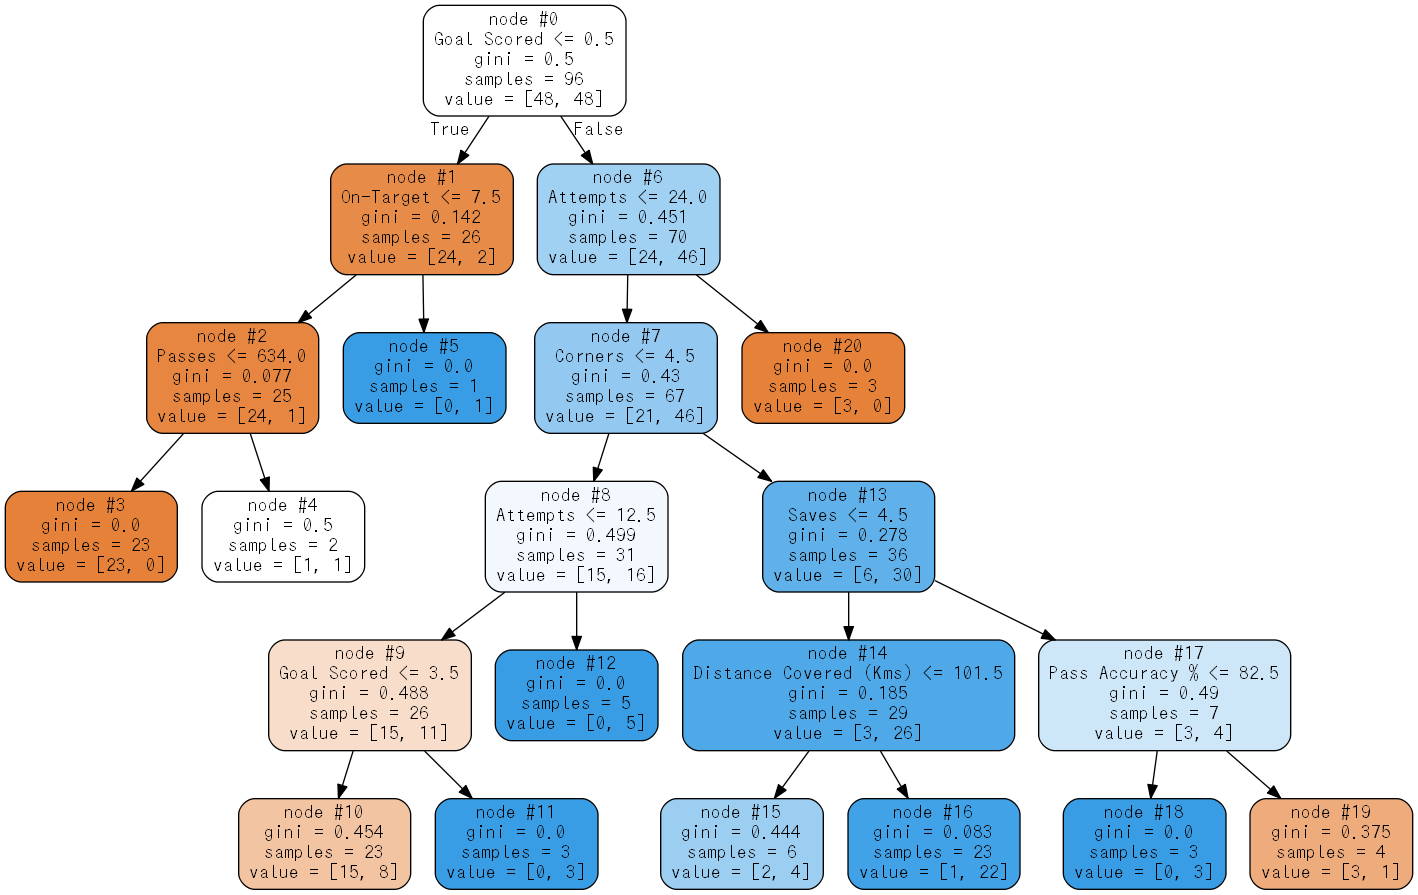

In [8]:
### decision tree

from sklearn import tree
import graphviz


def convert_decision_tree_to_ipython_image(clf,
                                           feature_names=None,
                                           class_names=None,
                                           image_filename=None,
                                           tmp_dir=None):
    """ plotting and saving png file decision tree """
    dot_filename = os.path.basename(image_filename).split(".")[0] + ".dot"

    tree.export_graphviz(
        clf,
        out_file=dot_filename,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        node_ids=True,
        special_characters=False)

    from IPython.display import Image
    image_filename = image_filename or ('%s.png' % dot_filename)

    subprocess.call(
        ('dot -Tpng -o %s %s' % (image_filename, dot_filename)).split(' '))
    image = Image(filename=image_filename)

    return image


convert_decision_tree_to_ipython_image(dtc, feature_names=X_train.columns, image_filename='dtc.png')

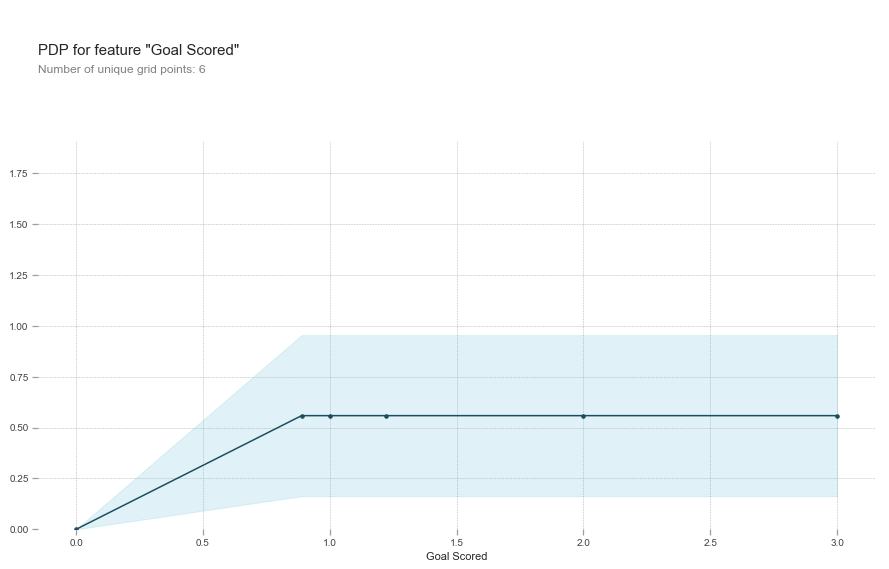

In [15]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Change "Goal Scored" and plot
pdp_goals = pdp.pdp_isolate(
    model=dtc, dataset=X_test, model_features=feats, feature='Goal Scored')
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

- y軸が予測値の変化
- 青背景部分は信頼区間
- x軸のデータ点はpdp_isolateのオプションで指定できる。  

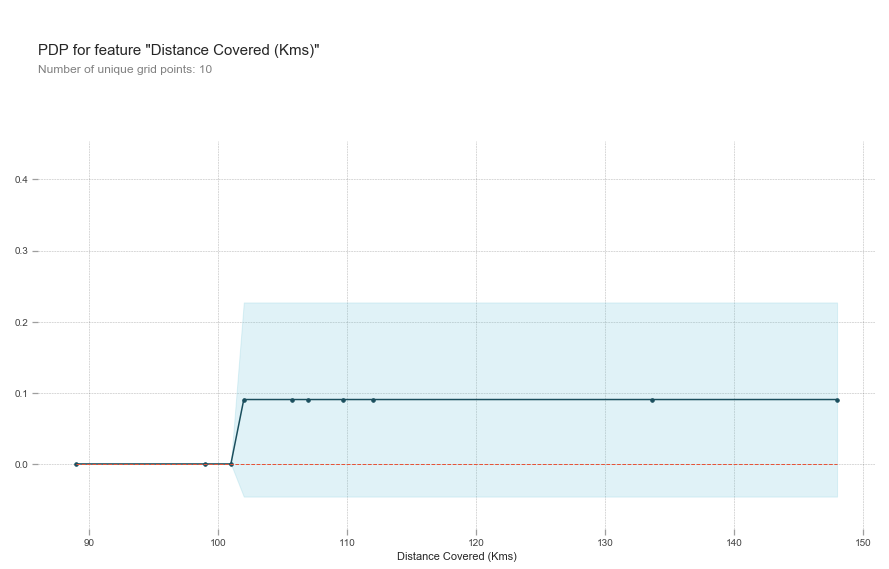

In [18]:
feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(
    model=dtc, dataset=X_test, model_features=feats, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

Distance Covered が102あたりで0.1。モデルのとおりになっている。

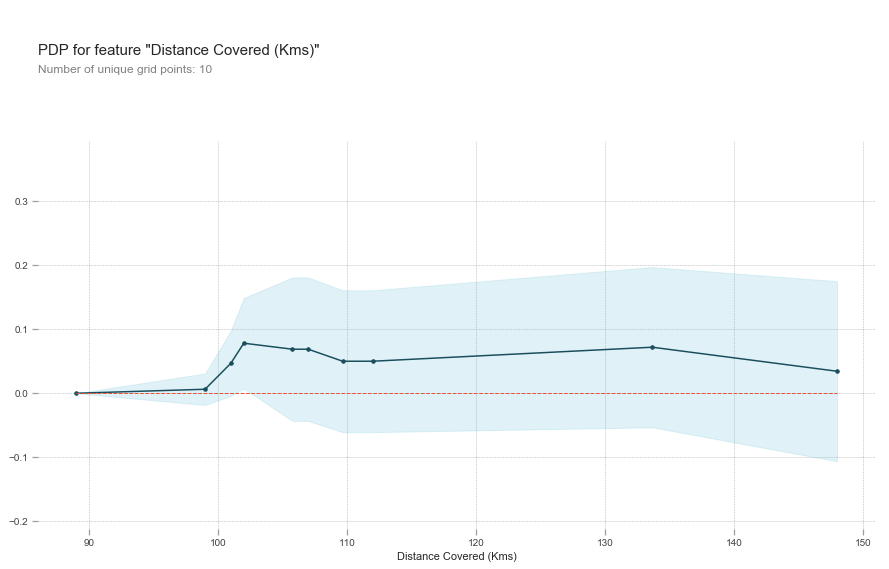

In [19]:
### random forest

rfc = RandomForestClassifier(random_state=SEED).fit(X_train, y_train)
pdp_dist = pdp.pdp_isolate(
    model=rfc, dataset=X_test, model_features=feats, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

- 決定木のときとは異なって、x軸の値ごとにy軸の値が変化している。
- 102kmあたりが最もyの値が大きい。

## 2D Partial Plot
これまでは1つの特徴量のみを変化させたが、2つの特徴量を変化させた場合のtargetの変化を見ることもできる。

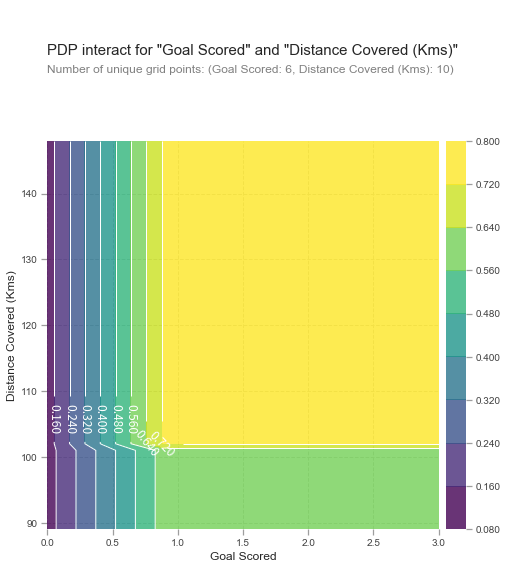

In [20]:
feature_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter = pdp.pdp_interact(
    model=dtc, dataset=X_test, model_features=feats, features=feature_to_plot)

pdp.pdp_interact_plot(
    pdp_interact_out=inter, feature_names=feature_to_plot, plot_type='contour')
plt.show()

- x軸がGoal Scored, y軸がDistance Covered, カラーバーがtargetを表す。
- Goal>1 ならば、Distance>100 のときに最も大きいtargetが得られる。
- Goal=0 ならば、Distanceに関係なくtargetの値は小さくなる。DistanceはGoal>0のときにしかtargetにほぼ影響しない。  

これらの傾向は、決定木からは読み取ることができない。


# Excercise
https://www.kaggle.com/dansbecker/exercise-partial-plots

## Q1

In [22]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../tools/ml-insights-tools')
from learntools.core import binder
binder.bind(globals())
from ex3 import *

DATA = '../data/new-york-city-taxi-fare-prediction/train.csv'

In [26]:
data = pd.read_csv(DATA, nrows=50000)
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and '
                  + 'fare_amount > 0')
base_feats = [
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
    'dropoff_latitude'
]

X = data[base_feats]
y = data.fare_amount
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [25]:
rfr = RandomForestRegressor(n_estimators=30, random_state=SEED).fit(X_train, y_train)

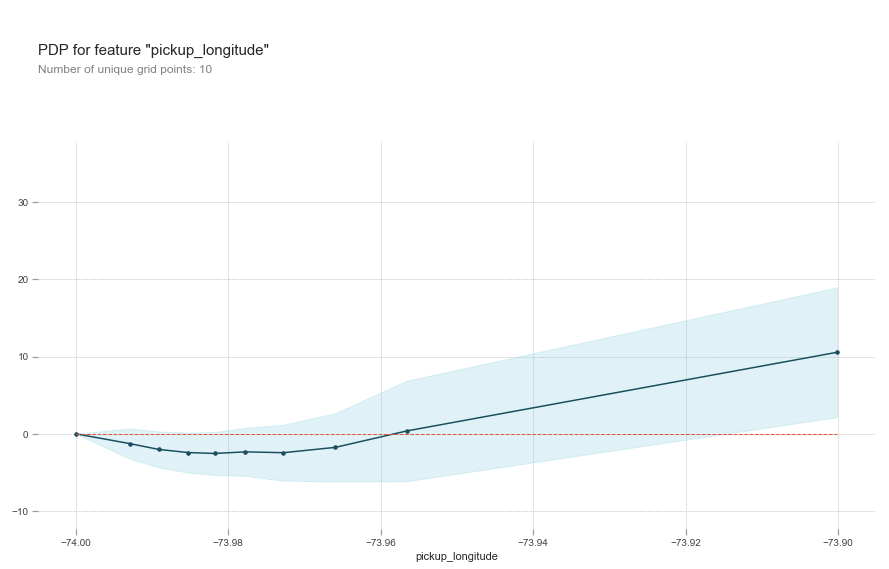

In [27]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feats = 'pickup_longitude'
pdp_dist = pdp.pdp_isolate(model=rfr, dataset=X_test, model_features=base_feats, feature=feats)
pdp.pdp_plot(pdp_dist, feats)
plt.show()

- y軸が負になっているのは、

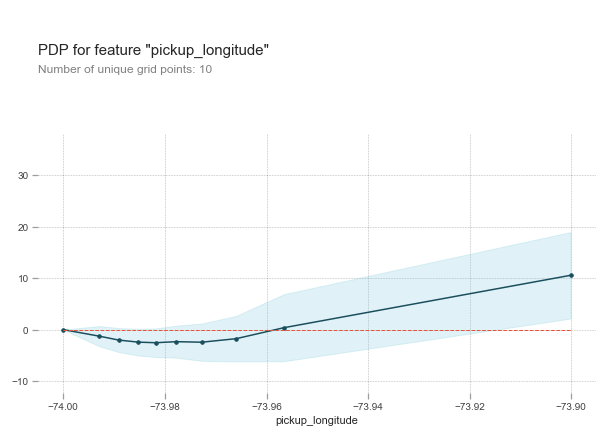

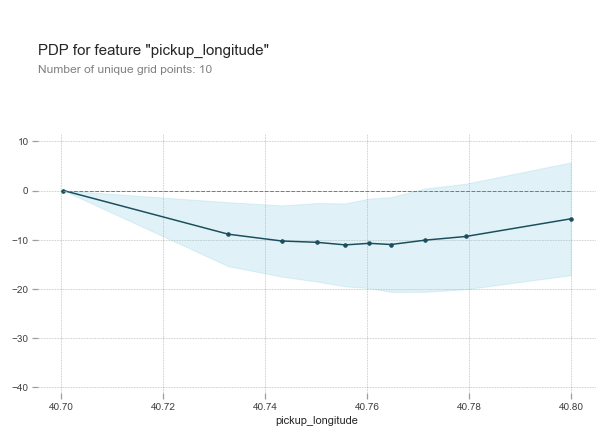

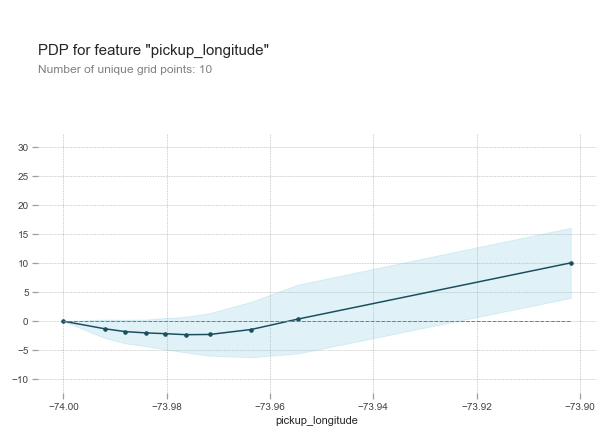

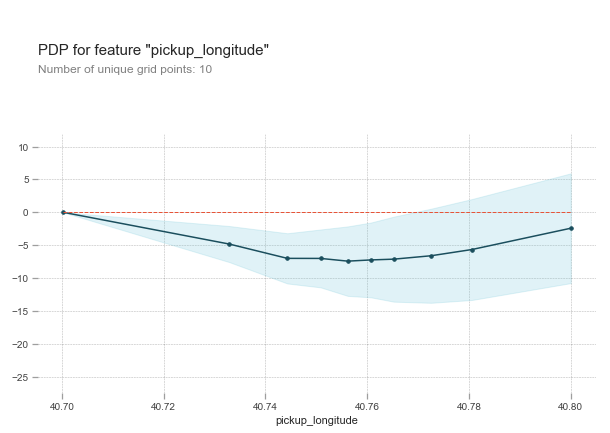

In [31]:
for c in base_feats:
    pdp_dist = pdp.pdp_isolate(model=rfr, dataset=X_test, model_features=base_feats, feature=c)
    pdp.pdp_plot(pdp_dist, feats, figsize=(10,7))
    plt.show()

In [32]:
q_1.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
The code is

    for feat_name in base_features:
        pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X,
                                   model_features=base_features, feature=feat_name)
        pdp.pdp_plot(pdp_dist, feat_name)
        plt.show()


We have a sense from the permutation importance results that distance is the most important determinant of taxi fare.

This model didn't include distance measures (like absolute change in latitude or longitude) as features, so coordinate features (like `pickup_longitude`) capture the effect of distance.
Being picked up near the center of the longitude values lowers predicted fares on average, because it means shorter trips (on average).

For the same reason, we see the general U-shape in all our partial dependence plots.


## Q2

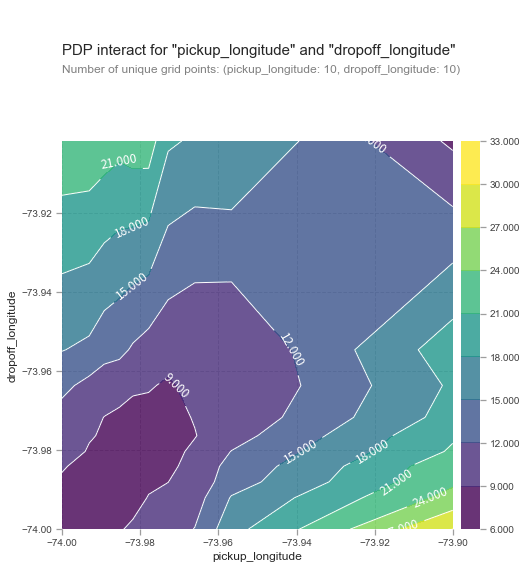

In [35]:
feature_to_plot = ['pickup_longitude', 'dropoff_longitude']
inter = pdp.pdp_interact(
    model=rfr,
    dataset=X_test,
    model_features=base_feats,
    features=feature_to_plot)

pdp.pdp_interact_plot(
    pdp_interact_out=inter, feature_names=feature_to_plot, plot_type='contour')
plt.show()

In [36]:
q_2.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
You should expect the plot to have contours running along a diagonal. We see that to some extent, though there are interesting caveats.

We expect the diagonal contours because these are pairs of values where the pickup and dropoff longitudes are nearby, indicating shorter trips (controlling for other factors).

As you get further from the central diagonal, we should expect prices to increase as the distances between the pickup and dropoff longitudes also increase.

The surprising feature is that prices increase as you go further to the upper-right of this graph, even staying near that 45-degree line.

This could be worth further investigation, though the effect of moving to the upper right of this graph is small compared to moving away from that 45-degree line.

The code you need to create the desired plot is:

    fnames = ['pickup_longitude', 'dropoff_longitude']
    longitudes_partial_plot  =  pdp.pdp_interact(model=first_model, dataset=val_X,
                                                model_features=base_features, features=fnames)
    pdp.pdp_interact_plot(pdp_interact_out=longitudes_partial_plot,
                          feature_names=fnames, plot_type='contour')
    plt.show()


## Q3

In [37]:
savings_from_shorter_trip = 12
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#cc3333">Incorrect</span>

## Q4

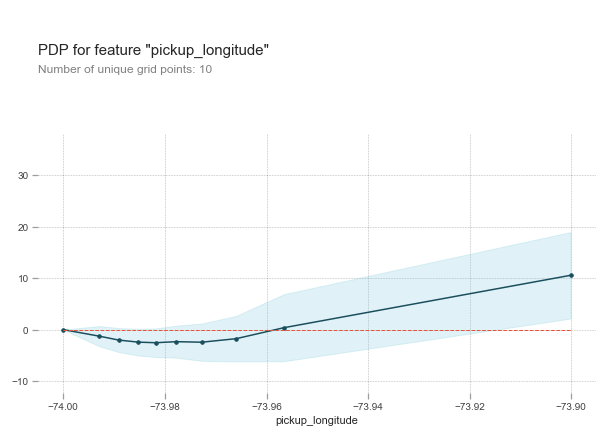

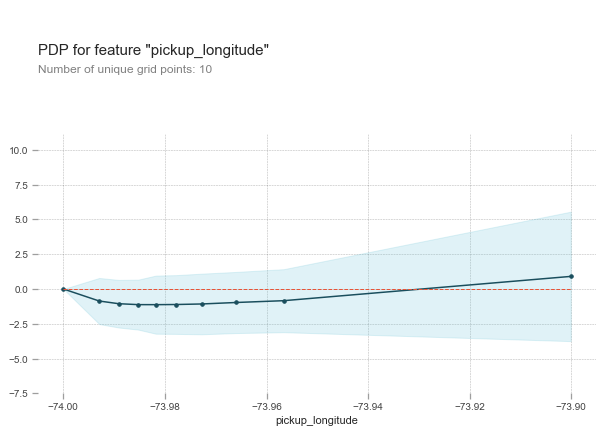

In [39]:
# set partial plot feature
feats = 'pickup_longitude'

# plot original model
pdp_dist_original = pdp.pdp_isolate(
    model=rfr, dataset=X_test, model_features=base_feats, feature=feats)
pdp.pdp_plot(pdp_dist_original, feats, figsize=(10,7))
plt.show()

# add features
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

# create new model
base_feats_new = [
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
    'dropoff_latitude', 'abs_lon_change', 'abs_lat_change'
]
X = data[base_feats_new]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X, y, random_state=SEED)
rfr_new = RandomForestRegressor(
    n_estimators=30, random_state=SEED).fit(X_train_new, y_train_new)

# plot new model
pdp_dist_original = pdp.pdp_isolate(
    model=rfr_new,
    dataset=X_test_new,
    model_features=base_feats_new,
    feature=feats)
pdp.pdp_plot(pdp_dist_original, feats, figsize=(10,7))
plt.show()

## Q5

In [43]:
q_5.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> No. This doesn't guarantee `feat_a` is more important. For example, `feat_a` could have a big effect in the cases where it varies, but could have a single value 99\% of the time. In that case, permuting `feat_a` wouldn't matter much, since most values would be unchanged.

## Q6

In [68]:
# create data
n_samples = 20000
X1 = 4 * np.random.rand(n_samples) - 2
X2 = 4 * np.random.rand(n_samples) - 2
y = np.ones(n_samples)

df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
X = df[['X1', 'X2']]
y = df['y']

In [70]:
# create model
rfr = RandomForestRegressor(n_estimators=30, random_state=SEED).fit(X, y)

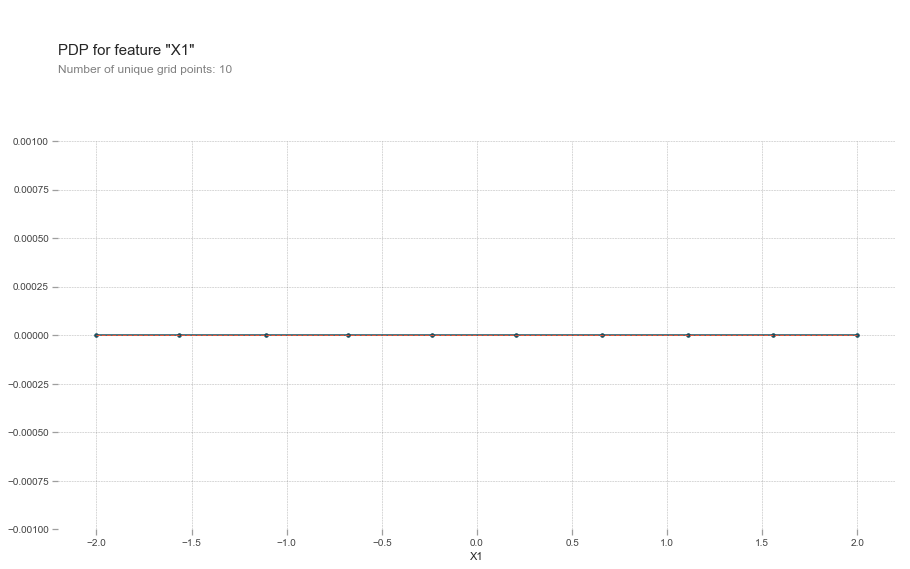

In [85]:
pdp_dist = pdp.pdp_isolate(
    model=rfr, dataset=df, model_features=['X1', 'X2'], feature='X1')
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()

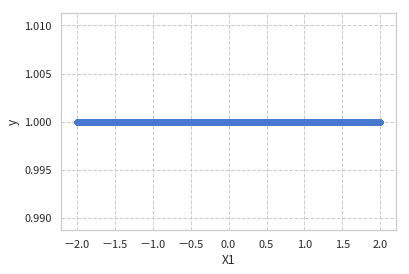

In [83]:
df.plot(x='X1', y='y', kind='scatter')

In [106]:
# create data
n_samples = 20000
X1 = 4 * np.random.rand(n_samples) - 2
X2 = 4 * np.random.rand(n_samples) - 2
y = -2 * X1 * (X1 < -1) + X1 - 2 * X1 * (X1 > 1) - X2

df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
X = df[['X1', 'X2']]
y = df['y']

In [108]:
# create model
rfr = RandomForestRegressor(n_estimators=30, random_state=SEED).fit(X, y)

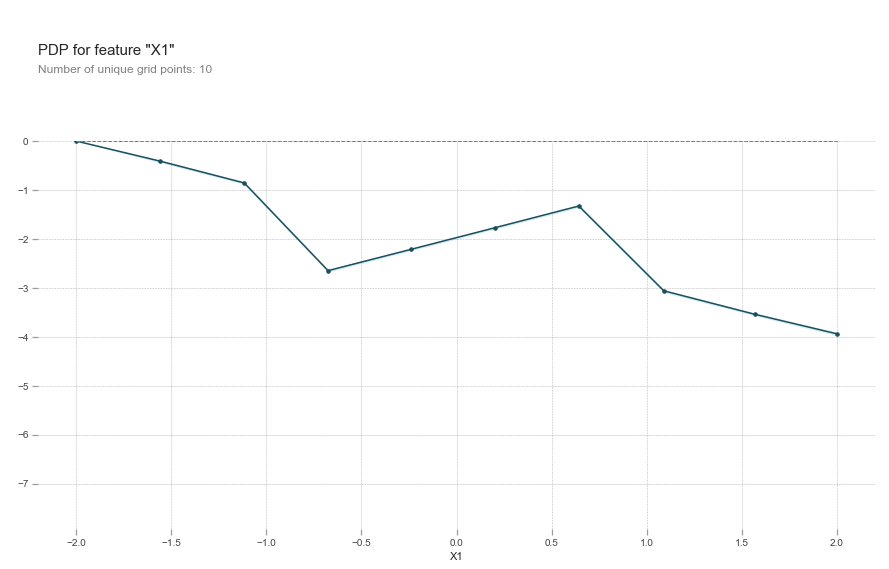

In [109]:
pdp_dist = pdp.pdp_isolate(
    model=rfr, dataset=df, model_features=['X1', 'X2'], feature='X1')
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()

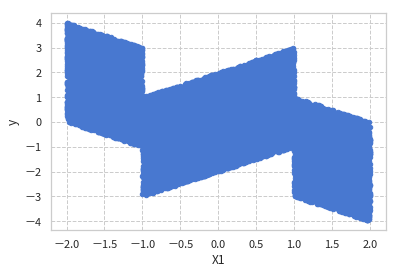

In [110]:
df.plot(x='X1', y='y', kind='scatter')

In [111]:
q_6.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>